import libraries

In [90]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import imghdr
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
# import plotly.express as px

from glob import glob
from shutil import copy
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# from tensorflow.keras.callbacks import TensorBoard
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.applications import InceptionResNetV2

In [100]:
# Defining functions
def predict_image(path):
    img=keras_image.load_img(path, target_size=(224,224))     # Load and resize the image
    img_array=keras_image.img_to_array(img)/255.0             # Convert image to array and rescale
    img_array=np.expand_dims(img_array, axis=0)               # Expand array dimentions to add batch size

    preds=loaded_model.predict(img_array)
    class_index=np.argmax(preds)
    
    print("Prediction probabilities:", preds[0])
    print("Predicted class:", class_names[class_index])

def predict_image_tl(path):
    img=keras_image.load_img(path, target_size=(224,224))
    img_array=keras_image.img_to_array(img)/255.0
    img_array=np.expand_dims(img_array, axis=0)

    preds=model_tl.predict(img_array)
    class_idx=np.argmax(preds[0])

    print("Prediction probabilities:", preds[0])
    print("Predicted class:", class_names[class_idx])

    return class_names[class_idx]

def predict_image_rf(path):
    img=keras_image.load_img(path,target_size=(224,224))
    img_array=keras_image.img_to_array(img)/255.0
    img_array=np.expand_dims(img_array, axis=0)

    feat=feature_extractor.predict(img_array)
    pred=rf.predict(feat)[0]

    print("RandomForest predicted:", class_names[pred])

    return class_names[pred]

In [45]:
# the base path/directory that contains all the folders
BASE_PATH = "/Users/aashi/Desktop/Machine Learning/ImageClassifier_Project"
# XML_PATH = os.path.join(BASE_PATH, "Annotations")
# the directory that contains the data/raw images
DATA_PATH = os.path.join(BASE_PATH, "Data")

In [ ]:
# actual_images=0
# remain_images=0
# removed_images=0

img_exts = ['jpeg','jpg','bmp','png']

for image_class in os.listdir(DATA_PATH):
    if image_class != ".DS_Store":
        for image in os.listdir(os.path.join(DATA_PATH, image_class)):
            # actual_images+=1
            IMAGE_PATH = os.path.join(DATA_PATH, image_class, image)
            try:
                img = cv2.imread(IMAGE_PATH)    # try to read the image
                tip = imghdr.what(IMAGE_PATH)   # try to decode the file format using imghdr
                if tip not in img_exts:
                    print('Image not in ext list {}'.format(IMAGE_PATH))
                    os.remove(IMAGE_PATH)
                    # removed_images+=1
            except Exception as e:
                print('Issue with image {}'.format(IMAGE_PATH))
            # remain_images+=1

In [ ]:
# print(f"Total images found: {actual_images}")
# print(f"Total images remaining: {remain_images}")
# print(f"Total images removed: {removed_images}")

Total images found: 439
Total images remaining: 439
Total images removed: 0


In [48]:
# Set parameters
IMG_SIZE=(224, 224)     # Image size
BATCH_SIZE=32           # Batch size

AUTOTUNE=tf.data.AUTOTUNE # Autotune buffer size


# Create training and validation datasets
train_ds=image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds=image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names=train_ds.class_names
print("Dectected classes:", class_names)

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 439 files belonging to 2 classes.
Using 352 files for training.
Found 439 files belonging to 2 classes.
Using 87 files for validation.
Dectected classes: ['bicycle', 'motorcycle']


In [49]:
# Build CNN model
num_classes=len(class_names)

# Adding data augmentation after running the CNN model once without it
data_augmentation=Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

model=Sequential([
    data_augmentation,
    Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), # 1. Normalize pixel values 0–255 → 0–1
    Conv2D(32, 3, activation='relu'),                             # 2. First convolutional block
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),                                 # 3. Fully connected layer
    Dropout(0.5),
    Dense(num_classes, activation='softmax')                       # 4. Output layer
])

# model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
EPOCHS=10

# Add early stopping callback after running the CNN model twice without it
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5580 - loss: 2.5490 - val_accuracy: 0.5402 - val_loss: 0.6820
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6172 - loss: 0.6555 - val_accuracy: 0.7126 - val_loss: 0.5936
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7636 - loss: 0.5266 - val_accuracy: 0.6897 - val_loss: 0.5931
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7077 - loss: 0.5799 - val_accuracy: 0.8046 - val_loss: 0.5474
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8069 - loss: 0.4816 - val_accuracy: 0.8161 - val_loss: 0.5235
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8237 - loss: 0.4191 - val_accuracy: 0.7816 - val_loss: 0.6225
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8410 - loss: 0.4003 - val_accuracy: 0.8046 - val_loss: 0.5648


In [52]:
model.save("bike_motor_cnn_model.h5")   # Save the trained model
print("Model saved successfully!")

Model saved successfully!


In [53]:
# Load the trained model
loaded_model=load_model("bike_motor_cnn_model.h5")
loaded_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,220 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [54]:
predict_image("Data/bicycle/bicycle-788733__340.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Prediction probabilities: [0.12576391 0.87423605]
Predicted class: motorcycle


In [55]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))

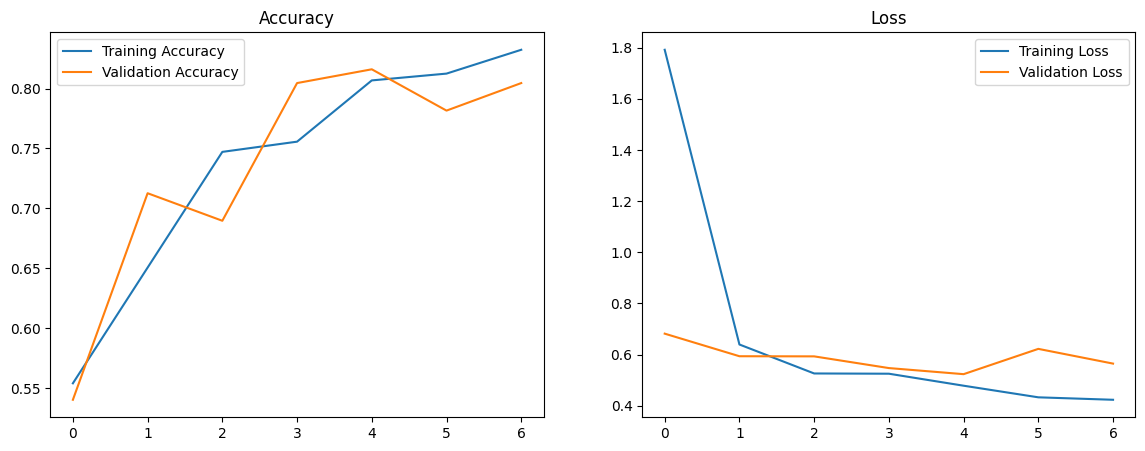

In [56]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

We built this as our base CNN model. Such small custom CNN models can detect edges but struggle with full object structure. Therefore, we switch to transfer learning with MobileNetV2-a pretrained model. MobileNetV2 was trained on 1.2 million images across 1000 classes. This is why transfer learning outperforms my handwritten CNN.

In [ ]:
# Load the pretrained MobileNetV2 model
base_model=MobileNetV2(
    weights="imagenet",     # Pretrained on ImageNet dataset
    include_top=False,      # Exclude the top classification layer
    input_tensor=Input(shape=(224,224,3))
)

base_model.trainable=False  # Freeze the base model

# Now we add our classification layers on top of the base model
x=base_model.output
x=GlobalAveragePooling2D()(x)   # Much smaller output than Flatten()
x=Dropout(0.3)(x)               # lighter dropout needed
output=Dense(num_classes, activation='softmax')(x)

model_tl=Model(inputs=base_model.input, outputs=output)

# Compile the model
model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the transfer learning model
history_tl=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5                # only few epochs needed
)

/var/folders/42/fz1qkw395yb0scnwfstgn9nr0000gn/T/ipykernel_20353/2457067732.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNetV2(


Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8165 - loss: 0.4250 - val_accuracy: 0.8161 - val_loss: 0.5868
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8316 - loss: 0.3767 - val_accuracy: 0.6667 - val_loss: 0.7596
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8056 - loss: 0.4527 - val_accuracy: 0.7471 - val_loss: 0.5796
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8258 - loss: 0.4121 - val_accuracy: 0.7931 - val_loss: 0.6993
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8732 - loss: 0.3157 - val_accuracy: 0.8046 - val_loss: 0.5179


Because the backbone is fully frozen, the network can’t adapt its deeper features to “bicycle vs motorcycle”. Therefore, we normally unfreeze some of the last layers and fine-tune with a smaller learning rate.

In [64]:
# Unfreeze some of the base model for fine tuning
base_model.trainable=True

# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable=False

len(base_model.layers), sum(layer.trainable for layer in base_model.layers)

(154, 20)

In [67]:
model_tl.compile(
    optimizer=Adam(learning_rate=1e-5),         # smaller learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [68]:
EPOCHS_FT=5     # Epochs for fine tuning

history_ft=model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT
)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_515']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5909 - loss: 0.7403 - val_accuracy: 0.6552 - val_loss: 0.6476
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6731 - loss: 0.6132 - val_accuracy: 0.6552 - val_loss: 0.6280
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7427 - loss: 0.5150 - val_accuracy: 0.6552 - val_loss: 0.6125
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7867 - loss: 0.4351 - val_accuracy: 0.6782 - val_loss: 0.6047
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8277 - loss: 0.4052 - val_accuracy: 0.6897 - val_loss: 0.6014


In [ ]:
# Predict using the fine-tuned model
# predict_image_tl("Data/bicycle/Bicycle-wheel-1366-0519.png")

correct={c: 0 for c in class_names}
total={c: 0 for c in class_names}

for class_name in class_names:
    class_folder=os.path.join(DATA_PATH, class_name)

    print("\nChecking class:", class_name)
    
    for img_file in os.listdir(class_folder):
        img_path=os.path.join(class_folder, img_file)

        total[class_name]+=1

        predicted_name=predict_image_tl(img_path)

        if predicted_name==class_name:
            correct[class_name]+=1


In [87]:
for c in class_names:
    print(f"{c}: {correct[c]}/{total[c]} correct")

bicycle: 158/215 correct
motorcycle: 151/224 correct


This model can do even better by fine tuning it further.

In [88]:
model_tl.save("bike_motor_mobilenetv2.h5")
print("Saved!")

Saved!


Now use MobileNet as a feature extractor + sklearn

In [95]:
# Take everything before the final dropout layer
feature_extractor=Model(
    inputs=model_tl.input,
    outputs=model_tl.layers[-2].output
)

X_train=[]
y_train=[]

for images, labels in train_ds:
    features=feature_extractor.predict(images)      # It does not mean to predict classes. But just run the images through MobileNetV2 up to the dropout layer and get back N-dimensional feature vectors.

    X_train.extend(features)
    y_train.extend(labels.numpy())

X_train=np.array(X_train)
y_train=np.array(y_train)

rf=RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_515']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


2025-11-29 20:23:11.167798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


RandomForestClassifier(n_estimators=200)

In [108]:
# Predict using the RF model
# predict_image_rf("Data/bicycle/Bicycle-wheel-1366-0519.png")

correct_rf={c: 0 for c in class_names}

for class_name in class_names:
    class_folder=os.path.join(DATA_PATH, class_name)

    # print("\nChecking class:", class_name)
    
    for img_file in os.listdir(class_folder):
        img_path=os.path.join(class_folder, img_file)

        predicted_name_rf=predict_image_rf(img_path)

        if predicted_name_rf==class_name:
            correct_rf[class_name]+=1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
RandomForest predicted: motorcycle
1/1 ━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
RandomForest predicted: bicycle
1/1 ━━━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
RandomForest predicted: moto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
RandomForest predicted: moto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
RandomForest predicted: bicycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
RandomForest predicted: motorcycle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RandomForest predicted: m

In [103]:
for c in class_names:
    print(f"{c}: {correct_rf[c]}/{total[c]} correct")

bicycle: 161/215 correct
motorcycle: 151/224 correct
